# We want to ask the question, "of the genes expressed, what is the distribution of editing among bulk RNA and how does that pattern compare to single-cell samples?"
- Plot edit % (percent of C-U / C across the UTR of a gene) for bulk and single cell and see if the pattern lines up.
- Do this in 3'UTR only to get a good comp between bulk and single cell samples

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pybedtools
import os
import glob
import gffutils
from Bio import SeqIO
from scipy import stats
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/inputs/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/outputs/'

# Original code from the notebooks: 
#  La_calculate_epkm_3utr.ipynb
#  Ma_join_epkm_3utr.ipynb

conf = 0.9

# Read in featureCounts outputs containing edit counts for each 3'UTR.
We've compiled edit counts at various conf levels by converting each edit BED file 
into a BAM file and calling featureCounts. For this analysis we're using 3'UTR annotations derived from ENSEMBL (10X)
We are calculating edit fraction as the number of C's that were confidently edited (per conf level above) divided by the number of total C's found along a gene's 3'UTR.

In [3]:
# from: /home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/SUPPLEMENTAL_bed_to_bam_and_featurecounts.ipynb
bulk_counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/counts_at_conf_{}.three_prime_utr.txt'.format(conf, conf)
print(bulk_counts_file, os.path.exists(bulk_counts_file))

# from: /home/bay001/projects/kris_apobec_20200121/permanent_data2/04_scRNA_RBFOX2_TIA/SUPPLEMENT_bed_to_bam_featurecounts.ipynb
scRNA_counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/04_scRNA_RBFOX2_TIA/outputs/all_scRNA_barcodes_counts.conf{}.three_prime_utr.txt'.format(conf)
# scRNA_counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/03_scRNA_APOBEC_RPS2/outputs/all_scRNA_barcodes_counts.conf{}.three_prime_utr.txt'.format(conf)
print(scRNA_counts_file, os.path.exists(scRNA_counts_file))

# from: /home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/SUPPLEMENT_bed_to_bam_featurecounts.ipynb
scRNA_all_counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/edit_featurecounts{}/counts_at_conf_{}.three_prime_utr.txt'.format(conf, conf)
print(scRNA_all_counts_file, os.path.exists(scRNA_all_counts_file))

/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts0.9/counts_at_conf_0.9.three_prime_utr.txt True
/home/bay001/projects/kris_apobec_20200121/permanent_data2/04_scRNA_RBFOX2_TIA/outputs/all_scRNA_barcodes_counts.conf0.9.three_prime_utr.txt True
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/edit_featurecounts0.9/counts_at_conf_0.9.three_prime_utr.txt True


# The following keys are to help us pull the columns we want from the edit counts matrices.
- This counts table comes from featureCounts output. 

### This file determines which BULK edits to compare

In [4]:
bulk_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/tmp/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam'.format(conf)
# bulk_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/tmp/Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam'.format(conf)
# bulk_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/tmp/Tia1_1000ng_2_S27_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam'.format(conf)
# bulk_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/tmp/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam'.format(conf)
# bulk_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/tmp/RPS3-1000_S19_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam'.format(conf)

### This file determines which single cell (AGGR) edits to compare

In [5]:
# sc_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/edit_featurecounts{}/tmp/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.sorted.bam'.format(conf)
# sc_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/edit_featurecounts{}/tmp/RPS2-STAMP_possorted_genome_bam_MD.sorted.bam'.format(conf)
sc_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/edit_featurecounts{}/tmp/RBFOX2-TIA1-STAMP_possorted_genome_bam_MD-34_barcodes.tsv.sorted.bam'.format(conf) # RBFOX2 'round2F'
# sc_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/edit_featurecounts{}/tmp/RBFOX2-TIA1-STAMP_possorted_genome_bam_MD-33_barcodes.tsv.sorted.bam'.format(conf) # TIA1 'round2F'

### These are background files that we can plot for any comparison

In [6]:
bg_bulk_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/edit_featurecounts{}/tmp/ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.sorted.bam'.format(conf)
bg_sc_key = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/edit_featurecounts{}/tmp/APOBEC-STAMP_possorted_genome_bam_MD.sorted.bam'.format(conf)

### This file determines which bulk dataset to SORT BY (top 200 expression)

In [7]:
# bulk_expr_key = '../results/Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam' # for Tia1
bulk_expr_key = 'results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
# bulk_expr_key = 'results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'

### Since we're sorting by top expressed cells, let's sort by the bulk expression (total)

In [8]:
# bulk_expr_counts = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200228_kris_rnaseq/featurecounts/counts.txt' # for Tia1
bulk_expr_counts = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.txt' # for RBFOX2 and RPS2

### This file determines which single-cell barcodes (individual) to plot.

In [9]:
barcodes_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/34_barcodes.tsv'
# barcodes_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/33_barcodes.tsv'
# barcodes_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt'

### Necessary for calculating the number of C's across a gene's 3'UTR

In [10]:
genome_fa = '/projects/ps-yeolab4/NCRCRG/refs/refdata-cellranger-hg19-3.0.0/fasta/genome.fa' # with chr1, chr2, etc.

### Calculated from /home/bay001/projects/kris_apobec_20200121/permanent_data2/04_scRNA_RBFOX2_TIA/21_sc_bed_to_bam_featurecounts.ipynb

In [11]:
SAF_file = os.path.join(input_dir, 'genes.three_prime_utr_only.SAF')

### Define filenames to write to.

In [12]:
output_lineplot = os.path.join(output_dir, 'fraction_edited_bulk_RBFOX2-1000_vs_scRNA_RBFOX2-844_conf0.9.DEEP.svg')
output_scatterplot = os.path.join(output_dir, 'fraction_edited_bulk_RBFOX2-1000_vs_scRNA_RBFOX2-844_conf0.9.DEEP.scatter.svg')

# Compute the number of C's across every gene's 3'UTR

#### Helper functions - these re-format existing 3'UTR annotations to be used for this analysis. 
- SAF file created with SUPPLEMENT_bed_to_bam_featurecounts.ipynb for use with featureCounts. Need to turn this into a BedTool.
- identical to /home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups/combined_outputs_w_cov_info/genes.three_prime_utr_only.SAF

In [13]:
def get_3utr_positions_as_df(SAF_file):
    """
    Returns the 3'UTR positions as annotated by SAF file created from 10X annotations.
    ie. {"gene_id":[
            {'chrom':chr1,'start':0,'end':100,'strand':"+"}, 
            {'chrom':chr1,'start':200,'end':300,'strand':"+"}, 
        ]}
    """
    df = pd.read_csv(SAF_file, names=['chrom','start','end','strand'], sep='\t', index_col=0)
    df['start'] = df['start'] - 1 # bed is 0-based, SAF is 1-based.
    df['score'] = 0
    
    return df

SAF = get_3utr_positions_as_df(SAF_file)

def get_3utr_positions_as_bedtool(geneid, SAF=SAF):
    try:
        df = SAF.loc[geneid].reset_index()[['chrom','start','end','index','score','strand']]
        return pybedtools.BedTool.from_dataframe(df).sort().merge(
            s=True, c="4,5,6", o="distinct,sum,distinct"
        )
    except KeyError:
        return pybedtools.BedTool.from_dataframe(pd.DataFrame(SAF.loc[geneid]).T.reset_index()[['chrom','start','end','index','score','strand']]).sort().merge(
            s=True, c="4,5,6", o="distinct,sum,distinct"
        )


SAF.head()

,chrom,start,end,strand,score
ENSG00000237683,1,137620,138529,-,0
ENSG00000237683,1,134900,135802,-,0
ENSG00000235249,1,368597,368634,+,0
ENSG00000185097,1,621058,621095,-,0
ENSG00000187634,1,879533,879955,+,0


#### Get all 3'UTR regions regardless of transcript. This dataframe should contain merged 3'UTR coordinates for each gene (ENSEMBL-style) now.

In [14]:
SAF.loc['ENSG00000184402']

,chrom,start,end,strand,score
ENSG00000184402,20,60754264,60754412,+,0
ENSG00000184402,20,60755224,60757533,+,0
ENSG00000184402,20,60754264,60757540,+,0
ENSG00000184402,20,60754264,60754412,+,0
ENSG00000184402,20,60755224,60757533,+,0
ENSG00000184402,20,60754264,60754412,+,0
ENSG00000184402,20,60755224,60755340,+,0


In [15]:
# Check to make sure we're getting the right coords (collapse transcript-level into gene-level coords)
get_3utr_positions_as_bedtool('ENSG00000184402').to_dataframe()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


,chrom,start,end,name,score,strand
0,20,60754264,60757540,ENSG00000184402,0,+


#### Now grab the sequences associated with these 3'UTR regions and count the number of C's.

In [16]:
def get_total_editable_sites(utr3_bedtool, genome_fa, debug=False):
    """
    Gets total number of total C's in each gene, returns dataframe.
    - negative strand returns reverse complement so always look for C
    """
    gene_sequence = utr3_bedtool.sequence(fi=genome_fa, s=True, name=True)
    total_editable = 0
    with open(gene_sequence.seqfn) as f:
        for record in SeqIO.parse(f, "fasta"):
            if debug:
                print("Sequence: [{}]".format(record.seq.upper()))
            total_editable += record.seq.upper().count('C')
            if debug:
                print("Number Cs found: {}".format(total_editable))
    return total_editable

#### Check the function to make sure it's working properly. We should be getting, for a given gene, the number of C's found in its 3'UTR.

In [17]:
get_total_editable_sites(
    utr3_bedtool=get_3utr_positions_as_bedtool('ENSG00000000419'),
    genome_fa=genome_fa,
    debug=True
)

Sequence: [AAGAAAGATACTCATTTATAGTTACGTTCATTTCAGGTTAAACATGAAAGAAGCCTGGTTACTGATTTGTATAAAATGTACTCTTAAAGTATAAAATATAAGGTAAGGTAAATTTCATGCATCTTTTTATGAAGACCACCTATTTTATATTTCAAATTAAATAATTTTAAAGTTGCTGGCCTAATGAGCAATGTTCTCAATTTTCGTTTTCATTTTGCTGTATTGAGACCTATAAATAAATGTATATTTTTTTTTGCATAAAGTA]
Number Cs found: 31


31

# Get number 'editable' sites for each gene.
- This is modified from Rb_check_exprs_against_bulk.ipynb to count C's along the 3'UTR instead of along the mRNA(CDS + UTR)
- Get the number of C's for each UTR, then divide the number of edits by this number to get a percentage.
- This takes about an hour or two, so just run this block once and comment out for reference later.

In [18]:
editable_df = pd.read_csv(os.path.join(output_dir, 'number_of_c_per_three_prime_utr.tsv'), sep='\t', index_col=0)
print(editable_df.shape[0])
editable_df.head()

19615


,number_of_C
ENSG00000169598,673
ENSG00000204538,149
ENSG00000113946,372
ENSG00000109471,31
ENSG00000125351,135


#### (TODO)I realize we need to also count total C's across exons if we're going to make that comparison also. 

In [19]:
def get_3utr_positions_as_bedtool(geneid, SAF=SAF):
    try:
        df = SAF.loc[geneid].reset_index()[['chrom','start','end','index','score','strand']]
        return pybedtools.BedTool.from_dataframe(df).sort().merge(
            s=True, c="4,5,6", o="distinct,sum,distinct"
        )
    except KeyError:
        return pybedtools.BedTool.from_dataframe(pd.DataFrame(SAF.loc[geneid]).T.reset_index()[['chrom','start','end','index','score','strand']]).sort().merge(
            s=True, c="4,5,6", o="distinct,sum,distinct"
        )

# Get number 'edited' vs 'editable' sites for each gene.
- read in a featurecounts file that I've made before, where each 'count' is an edit along the 3'UTR region of a gene.
- use the above 'bulk key' to define which column contains our edit counts.

In [20]:
edits = pd.read_csv(
    bulk_counts_file, 
    skiprows=1, 
    sep='\t', 
    index_col=0
).iloc[:,5:][[bulk_key, bg_bulk_key]]
edits.columns = ['bulk_edited', 'bg_bulk_edited']
print(edits.shape[0])
edits.head()

19615


,bulk_edited,bg_bulk_edited
Geneid,,
ENSG00000237683,0,0
ENSG00000235249,0,0
ENSG00000185097,0,0
ENSG00000187634,0,0
ENSG00000188976,4,0


# Since the featureCounts for whole gene (Exons) is from Gencode but the 3'UTR annotations are from ENSEMBL, we need to check gene IDs otherwise the merges won't work properly.

In [21]:
edits.reset_index(inplace=True)
edits['Geneid_ensembl_style'] = edits['Geneid'].apply(lambda x: x.split('.')[0])
edits.set_index('Geneid_ensembl_style', inplace=True)
del edits['Geneid']
edits.head()

,bulk_edited,bg_bulk_edited
Geneid_ensembl_style,,
ENSG00000237683,0,0
ENSG00000235249,0,0
ENSG00000185097,0,0
ENSG00000187634,0,0
ENSG00000188976,4,0


# Using geneID as a key, merge the 'edit count' (bulk_edited) and 'number_of_C' and calculate the fraction of C's that were edited compared to total
- going from 19615 entries to 19572 entries because we're dropping any gene whose 3'UTR has zero editable sites (and thus dividing by zero returns NaN)

In [22]:
merged = pd.merge(editable_df, edits, how='outer', left_index=True, right_index=True)
merged['fraction_edited'] = merged['bulk_edited'].div(merged['number_of_C'])
merged['bg_fraction_edited'] = merged['bg_bulk_edited'].div(merged['number_of_C'])
merged.sort_values(by=['number_of_C'], inplace=True, ascending=False)
merged.dropna(inplace=True)
print(merged.shape[0])
merged.head(15)

19593


,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited
ENSG00000273079,4509,0,0,0.000000,0.000000
ENSG00000215193,4355,31,1,0.007118,0.000230
ENSG00000138443,4154,91,0,0.021907,0.000000
ENSG00000003402,3989,5,0,0.001253,0.000000
ENSG00000145012,3946,11,2,0.002788,0.000507
ENSG00000171435,3820,0,0,0.000000,0.000000
ENSG00000157542,3765,0,0,0.000000,0.000000
ENSG00000055609,3758,6,1,0.001597,0.000266
ENSG00000153721,3750,11,0,0.002933,0.000000
ENSG00000108219,3722,16,0,0.004299,0.000000


##### sanity check, since we're using the same annotations we don't expect any mis-alignments in merging. However this changes in the next few cells.

In [23]:
merged[pd.isnull(merged).any(axis=1)] 

,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited


# Get gene expression results (and convert to TPM)
- using whole gene (exons) expression now. I'd like to keep things as simple as possible, so these top expressed genes should be the same across analyses

In [24]:
def counts_to_rpkm(feature_counts_table):
    """
    takes featureCounts counts.txt and returns RPKM
    """
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table, skip_col=5):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return tpm

counts_table = pd.read_csv(bulk_expr_counts, sep='\t', index_col=0, skiprows=1)
counts_table = counts_table[['Chr','Start','End','Strand','Length', bulk_expr_key]]
counts_table.head()

,Chr,Start,End,Strand,Length,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,,,,,
ENSG00000223972.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,11869;11872;11874;12010;12179;12595;12613;1261...,12227;12227;12227;12057;12227;12721;12697;1272...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,1756,0
ENSG00000227232.4,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14363;14363;14404;14411;14970;14970;1497...,14829;14829;14829;14501;14502;15038;15038;1503...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,2073,140
ENSG00000243485.2,chr1;chr1;chr1;chr1;chr1;chr1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31109;31097,+;+;+;+;+;+,1021,0
ENSG00000237613.2,chr1;chr1;chr1;chr1;chr1,34554;35245;35277;35721;35721,35174;35481;35481;36081;36073,-;-;-;-;-,1219,0
ENSG00000268020.2,chr1;chr1;chr1,52473;53049;54830,53312;53067;54936,+;+;+,947,12


In [25]:
# Just save in case we need it.
tpm = counts_to_tpm(counts_table)
tpm.sort_values(by=[bulk_expr_key], inplace=True, ascending=False)
tpm.to_csv(os.path.join(output_dir, 'counts.tpm.txt'), sep='\t')

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


#### Convert gene expression IDs to ensembl-style
- remove the 'dot' to make the index identical to Ensembl-style format.

In [26]:
tpm.index.rename('Gencode_geneid', inplace=True)
tpm.reset_index(inplace=True)
tpm['Geneid'] = tpm['Gencode_geneid'].apply(lambda x: x.split('.')[0])
del tpm['Gencode_geneid']
tpm.set_index('Geneid', inplace=True)
print(tpm.shape[0])
tpm.head()

57820


,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,
ENSG00000210082,51589.354216
ENSG00000198804,21088.463839
ENSG00000211459,16471.228290
ENSG00000198886,16021.805615
ENSG00000140988,10863.113685


# Merge gene expression w/ edit %
- outer merge NaNs mean that we have expression counts (from featureCounts on gencode gtf) but no UTR annotations (from previous 3'UTR SAF file). 

In [27]:
print("Merged shape before merging with tpm counts: {}".format(merged.shape[0]))
merged = pd.merge(tpm, merged, how='outer', left_index=True, right_index=True)
merged['log2_tpm'] = np.log2(merged[bulk_expr_key])
merged.sort_values(by='log2_tpm', ascending=True, inplace=True)
print("Merged shape after merging with tpm counts: {}".format(merged.shape[0]))
merged = merged.dropna()
print("Merged shape after merging with tpm counts and dropping NaNs: {}".format(merged.shape[0]))
merged.head()

Merged shape before merging with tpm counts: 19593
Merged shape after merging with tpm counts: 57841
Merged shape after merging with tpm counts and dropping NaNs: 19572


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited,log2_tpm
ENSG00000243207,0.0,341.0,0.0,0.0,0.0,0.0,-inf
ENSG00000213927,0.0,10.0,0.0,0.0,0.0,0.0,-inf
ENSG00000213920,0.0,17.0,0.0,0.0,0.0,0.0,-inf
ENSG00000213906,0.0,80.0,0.0,0.0,0.0,0.0,-inf
ENSG00000243232,0.0,475.0,0.0,0.0,0.0,0.0,-inf


# [Sanity check] Check the genes with no expression but with nonzero edit %
- There are some genes with "no expression" but this is all due to overlapping annotations (using counts.overlapping.multimapping.txt includes these genes)

In [28]:
print(merged[
    (merged['fraction_edited']>0) & \
    (merged[bulk_expr_key]==0)
].shape[0])
merged[
    (merged['fraction_edited']>0) & \
    (merged[bulk_expr_key]==0)
].tail()

41


,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited,log2_tpm
ENSG00000257207,0.0,577.0,1.0,0.0,0.001733,0.000000,-inf
ENSG00000154545,0.0,56.0,1.0,0.0,0.017857,0.000000,-inf
ENSG00000254806,0.0,269.0,2.0,0.0,0.007435,0.000000,-inf
ENSG00000254413,0.0,803.0,2.0,1.0,0.002491,0.001245,-inf
ENSG00000254870,0.0,431.0,1.0,0.0,0.002320,0.000000,-inf


# Filter with just the expressed genes (TPM > 0) and plot fraction edited.

In [29]:
merged_expressed_only = merged[merged[bulk_expr_key] > 0]
# merged_expressed_only = merged[merged['log2_tpm'] >= 1]
print(merged_expressed_only.shape[0])
# fig, ax = plt.subplots(figsize=(45, 5))
# ax = merged_expressed_only['fraction_edited'].plot(style='-', linewidth=0.1)
merged_expressed_only.head()

15832


,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited,log2_tpm
ENSG00000273079,0.003262,4509.0,0.0,0.0,0.0,0.0,-8.259909
ENSG00000205277,0.005183,135.0,0.0,0.0,0.0,0.0,-7.591926
ENSG00000188107,0.005201,708.0,0.0,0.0,0.0,0.0,-7.586864
ENSG00000198838,0.005535,157.0,0.0,0.0,0.0,0.0,-7.497165
ENSG00000111452,0.006032,589.0,0.0,0.0,0.0,0.0,-7.373178


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


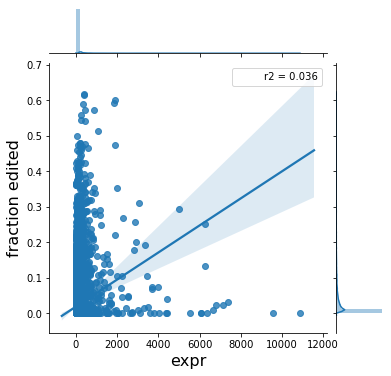

In [30]:
# No correlation between TPM expression and fraction of edited C's.

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

plot = sns.jointplot(
    x=bulk_expr_key, 
    y='fraction_edited', 
    data=merged, 
    kind="reg", 
    stat_func=r2
)

# JointGrid has a convenience function to label jointplots.
plot.set_axis_labels('expr', 'fraction edited', fontsize=16)

# Perform the same analysis with scRNA

- Get individually-specific barcodes. 
- Read in the 'edits counts matrix' and select edit counts based on the RBFOX2-expressed barcodes
- Convert gene IDs so they are comparable to bulk

In [31]:
df = pd.read_csv(barcodes_file, names=['barcodes'])
barcodes = list(df['barcodes'])
print(len(barcodes))

844


In [32]:
sc_edits = pd.read_csv(
    scRNA_counts_file, sep='\t', index_col=0
)
sc_edits.head()

,/possorted_genome_bam_MD-AAACCCAAGAGCCCAA-1.sorted.bam,/possorted_genome_bam_MD-AAACCCAAGAGCTTTC-1.sorted.bam,/possorted_genome_bam_MD-AAACCCAAGATAGTGT-1.sorted.bam,/possorted_genome_bam_MD-AAACCCAAGTCCGTCG-1.sorted.bam,/possorted_genome_bam_MD-AAACCCAAGTGCTACT-1.sorted.bam,/possorted_genome_bam_MD-AAACCCACAGAAATTG-1.sorted.bam,/possorted_genome_bam_MD-AAACCCACAGGAAGTC-1.sorted.bam,/possorted_genome_bam_MD-AAACCCACAGGCTCTG-1.sorted.bam,/possorted_genome_bam_MD-AAACCCACATATGCGT-1.sorted.bam,/possorted_genome_bam_MD-AAACCCACATCTATCT-1.sorted.bam,...,/possorted_genome_bam_MD-TTTGTTGGTATTCCGA-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGGTCTCACAA-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGGTGAATTAG-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGGTTAAGTCC-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGGTTGGAGGT-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGTCACTCGAA-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGTCATTTCCA-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGTCCTATGGA-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGTCCTTCTGG-1.sorted.bam,/possorted_genome_bam_MD-TTTGTTGTCGAGAAAT-1.sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000237683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000235249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000187634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000188976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
columns = []
 
# This is for TIA/RBFOX

for barcode in barcodes:
    columns.append(
        '/possorted_genome_bam_MD-{}.sorted.bam'.format(
            barcode
        )
    )


"""
for barcode in barcodes:
    columns.append(
        '/RPS2_possorted_genome_bam_MD-{}.sorted.bam'.format(
            barcode
        )
    )
"""
print(len(columns))
columns[:3]

844


['/possorted_genome_bam_MD-AAACGAAAGTCACACT-1.sorted.bam',
 '/possorted_genome_bam_MD-AAACGAACAGATCATC-1.sorted.bam',
 '/possorted_genome_bam_MD-AAACGAACATGACTAC-1.sorted.bam']

## Select only the barcodes with measured ORF expr (ie. 844 for RBFOX) and re-format the colnames to remove the extraneous stuff.

In [34]:
sc_edits = sc_edits[columns]
sc_edits.columns = [
    c.replace('/possorted_genome_bam_MD-', '').replace('.sorted.bam','').replace('/RPS2_possorted_genome_bam_MD-','') for c in sc_edits.columns
]
print(sc_edits.shape)
sc_edits.head()

(19615, 844)


,AAACGAAAGTCACACT-1,AAACGAACAGATCATC-1,AAACGAACATGACTAC-1,AAAGAACAGACTCCGC-1,AAAGGATAGATGACCG-1,AAAGGATCAGTCAACT-1,AAAGGGCAGTAAACGT-1,AAAGGTAAGCGATGGT-1,AAAGGTACAGACCTGC-1,AAAGGTAGTGGATGAC-1,...,TTTATGCAGCCTCTCT-1,TTTATGCAGTTCCATG-1,TTTATGCTCTTTCAGT-1,TTTCATGCACAATGAA-1,TTTCCTCCAACAGATA-1,TTTCGATAGCCTCTGG-1,TTTCGATGTAATCAGA-1,TTTGGTTCAGCACAAG-1,TTTGGTTTCCTACCGT-1,TTTGTTGGTATTCCGA-1
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000237683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000235249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000187634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000188976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Compute edited fraction (number of edited C's divided by the number of C's in gene 3UTR) for every individual cell barcode.

In [35]:
sc_edited_fraction = sc_edits.div(editable_df['number_of_C'], axis=0).dropna()
print(sc_edited_fraction.shape[0])
sc_edited_fraction.head()

19593


,AAACGAAAGTCACACT-1,AAACGAACAGATCATC-1,AAACGAACATGACTAC-1,AAAGAACAGACTCCGC-1,AAAGGATAGATGACCG-1,AAAGGATCAGTCAACT-1,AAAGGGCAGTAAACGT-1,AAAGGTAAGCGATGGT-1,AAAGGTACAGACCTGC-1,AAAGGTAGTGGATGAC-1,...,TTTATGCAGCCTCTCT-1,TTTATGCAGTTCCATG-1,TTTATGCTCTTTCAGT-1,TTTCATGCACAATGAA-1,TTTCCTCCAACAGATA-1,TTTCGATAGCCTCTGG-1,TTTCGATGTAATCAGA-1,TTTGGTTCAGCACAAG-1,TTTGGTTTCCTACCGT-1,TTTGTTGGTATTCCGA-1
ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Merge 10X edited fractions with the merged master table from above (only care about expressed genes)
- from 19572 -> 15832 due to removing non-expressed genes

In [36]:
merged_expressed_only_and_sc = pd.merge(merged_expressed_only, sc_edited_fraction, how='left', left_index=True, right_index=True)
merged_expressed_only_and_sc.fillna(0, inplace=True)
print(merged_expressed_only_and_sc.shape[0])
merged_expressed_only_and_sc.head()

15832


,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited,log2_tpm,AAACGAAAGTCACACT-1,AAACGAACAGATCATC-1,AAACGAACATGACTAC-1,...,TTTATGCAGCCTCTCT-1,TTTATGCAGTTCCATG-1,TTTATGCTCTTTCAGT-1,TTTCATGCACAATGAA-1,TTTCCTCCAACAGATA-1,TTTCGATAGCCTCTGG-1,TTTCGATGTAATCAGA-1,TTTGGTTCAGCACAAG-1,TTTGGTTTCCTACCGT-1,TTTGTTGGTATTCCGA-1
ENSG00000273079,0.003262,4509.0,0.0,0.0,0.0,0.0,-8.259909,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000205277,0.005183,135.0,0.0,0.0,0.0,0.0,-7.591926,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188107,0.005201,708.0,0.0,0.0,0.0,0.0,-7.586864,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000198838,0.005535,157.0,0.0,0.0,0.0,0.0,-7.497165,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000111452,0.006032,589.0,0.0,0.0,0.0,0.0,-7.373178,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
merged_expressed_only_and_sc.head()

,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited,log2_tpm,AAACGAAAGTCACACT-1,AAACGAACAGATCATC-1,AAACGAACATGACTAC-1,...,TTTATGCAGCCTCTCT-1,TTTATGCAGTTCCATG-1,TTTATGCTCTTTCAGT-1,TTTCATGCACAATGAA-1,TTTCCTCCAACAGATA-1,TTTCGATAGCCTCTGG-1,TTTCGATGTAATCAGA-1,TTTGGTTCAGCACAAG-1,TTTGGTTTCCTACCGT-1,TTTGTTGGTATTCCGA-1
ENSG00000273079,0.003262,4509.0,0.0,0.0,0.0,0.0,-8.259909,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000205277,0.005183,135.0,0.0,0.0,0.0,0.0,-7.591926,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188107,0.005201,708.0,0.0,0.0,0.0,0.0,-7.586864,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000198838,0.005535,157.0,0.0,0.0,0.0,0.0,-7.497165,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000111452,0.006032,589.0,0.0,0.0,0.0,0.0,-7.373178,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### or we select certain genes to look at edit % for both bulk and each of the single cell 10x barcodes that show measured RBFOX2 expression"

In [38]:
# pd.DataFrame(merged_expressed_only_and_sc.loc[['ENSG00000164032', 'ENSG00000164104']]).T.head()

#### Check one of them carefully to make sure everything is correct so far:
@ ENSG00000164104

In [39]:
gene_interval = pybedtools.create_interval_from_list(
    [
        '4', '174252846', '174253230', 'ENSG00000164104', '0', '-'
    ]
)
gene_bedtool = pybedtools.BedTool([gene_interval])
gene_sequence = gene_bedtool.sequence(fi=genome_fa, s=True, name=True)

with open(gene_sequence.seqfn) as f:
    for record in SeqIO.parse(f, "fasta"):
        print("Sequence: [{}]".format(record.seq.upper()))
        total_editable = record.seq.upper().count('C')
print(total_editable)

Sequence: [ATGGCTATCCTTTAATGATGCGTGTGGAATGTGTGTGTGTGCTCAGGCAATTATTTTGCTAAGAATGTGAATTCAAGTGCAGCTCAATACTAGCTTCAGTATAAAAACTGTACAGATTTTTGTATAGCTGATAAGATTCTCTGTAGAGAAAATACTTTTAAAAAATGCAGGTTGTAGCTTTTTGATGGGCTACTCATACAGTTAGATTTTACAGCTTCTGATGTTGAATGTTCCTAAATATTTAATGGTTTTTTTAATTTCTTGTGTATGGTAGCACAGCAAACTTGTAGGAATTAGTATCAATAGTAAATTTTGGGTTTTTTAGGATGTTGCATTTCGTTTTTTTAAAAAAAATTTTGTAATAAAATTATGTATATTATTTCT]
41


In [40]:
# pd.DataFrame(sc_rbfox2_edits.loc['ENSG00000164104']).sort_values(by='ENSG00000164104', ascending=False).head()

# Run the analysis on RBFOX2 group of barcodes "aggr" 
- All 844 barcodes merged into a single BAM file, then run SAILOR to get edits
- This should be done after following the notebook order.
- Use the 'sc_key' to define which columns to get our edit counts from. This should correspond to the filename of the aggregate group that we called SAILOR on.

In [41]:
all_sc_edits = pd.read_csv(
    scRNA_all_counts_file, skiprows=1, sep='\t', index_col=0
).iloc[:,5:][[sc_key, bg_sc_key]]
all_sc_edits.columns = ['aggr_sc_edited', 'bg_aggr_sc_edited']
all_sc_edits.head()

,aggr_sc_edited,bg_aggr_sc_edited
Geneid,,
ENSG00000237683,0,1
ENSG00000235249,0,0
ENSG00000185097,0,0
ENSG00000187634,0,0
ENSG00000188976,2,0


In [42]:
merged = pd.merge(editable_df, all_sc_edits, how='outer', left_index=True, right_index=True)
print(merged.shape[0])
merged['aggr_sc_fraction_edited'] = merged['aggr_sc_edited'].div(merged['number_of_C'])
merged['bg_aggr_sc_fraction_edited'] = merged['bg_aggr_sc_edited'].div(merged['number_of_C'])
merged.sort_values(by=['number_of_C'], inplace=True, ascending=False)
merged.head(15)

19615


,number_of_C,aggr_sc_edited,bg_aggr_sc_edited,aggr_sc_fraction_edited,bg_aggr_sc_fraction_edited
ENSG00000273079,4509,0,0,0.000000,0.000000
ENSG00000215193,4355,3,3,0.000689,0.000689
ENSG00000138443,4154,4,0,0.000963,0.000000
ENSG00000003402,3989,0,3,0.000000,0.000752
ENSG00000145012,3946,4,1,0.001014,0.000253
ENSG00000171435,3820,0,0,0.000000,0.000000
ENSG00000157542,3765,0,0,0.000000,0.000000
ENSG00000055609,3758,8,2,0.002129,0.000532
ENSG00000153721,3750,4,2,0.001067,0.000533
ENSG00000108219,3722,2,0,0.000537,0.000000


#### Why are some of these genes edited but C's cannot be found?
- These genes (ie. ENSG00000215699, ENSG00000215781, ENSG00000215700) are all found on noncanonical chromosomes (chr1_gl000191_random:29663-33264). We can probably drop them.

In [43]:
for gene in merged[merged['aggr_sc_fraction_edited'] == np.inf].index:
    print(gene, get_total_editable_sites(
        utr3_bedtool=get_3utr_positions_as_bedtool(gene),
        genome_fa=genome_fa,
        debug=True
    ))

# 

# Finally, let's join the master table (merged_expressed_only_and_sc) with aggr edit % (merged)

In [44]:
merged_expressed_only_and_sc_and_aggr = pd.merge(merged_expressed_only_and_sc, merged[['aggr_sc_fraction_edited', 'bg_aggr_sc_fraction_edited']], how='left', left_index=True, right_index=True)
merged_expressed_only_and_sc_and_aggr.fillna(0, inplace=True)
print(merged_expressed_only_and_sc_and_aggr.shape[0])
merged_expressed_only_and_sc_and_aggr.head()

15832


,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited,log2_tpm,AAACGAAAGTCACACT-1,AAACGAACAGATCATC-1,AAACGAACATGACTAC-1,...,TTTATGCTCTTTCAGT-1,TTTCATGCACAATGAA-1,TTTCCTCCAACAGATA-1,TTTCGATAGCCTCTGG-1,TTTCGATGTAATCAGA-1,TTTGGTTCAGCACAAG-1,TTTGGTTTCCTACCGT-1,TTTGTTGGTATTCCGA-1,aggr_sc_fraction_edited,bg_aggr_sc_fraction_edited
ENSG00000273079,0.003262,4509.0,0.0,0.0,0.0,0.0,-8.259909,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000205277,0.005183,135.0,0.0,0.0,0.0,0.0,-7.591926,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188107,0.005201,708.0,0.0,0.0,0.0,0.0,-7.586864,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000198838,0.005535,157.0,0.0,0.0,0.0,0.0,-7.497165,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000111452,0.006032,589.0,0.0,0.0,0.0,0.0,-7.373178,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## No more tab manipulation, so let's convert geneid's to gene names (easier to read). Be careful, I use gene ids as indices to join tables, not gene names!

In [45]:
def gene_id_to_name(db):
    """
    Returns a dictionary containing a gene_id:name translation
    Note: may be different if the 'gene_id' or 'gene_name' 
    keys are not in the source GTF file
    (taken from gscripts.region_helpers)
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0].split('.')[0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id'].split('.')[0]
        try:
            gene_name_dict[gene_id] = gene.attributes['gene_name'][0]
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

db_file = '/projects/ps-yeolab3/bay001/annotations/hg19/gencode_v19/gencode.v19.annotation.gtf.db'
DATABASE = gffutils.FeatureDB(db_file)
gene_id_to_name_dictionary = gene_id_to_name(DATABASE)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [46]:
def get_gene_names(row, d=gene_id_to_name_dictionary):
    try:
        return d[row['index']]
    except KeyError:
        return 'intergenic'

merged_expressed_only_and_sc_and_aggr.reset_index(inplace=True)
merged_expressed_only_and_sc_and_aggr['Genename'] = merged_expressed_only_and_sc_and_aggr.apply(get_gene_names, axis=1)
merged_expressed_only_and_sc_and_aggr.set_index('Genename', inplace=True)
merged_expressed_only_and_sc_and_aggr.head()

,index,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,number_of_C,bulk_edited,bg_bulk_edited,fraction_edited,bg_fraction_edited,log2_tpm,AAACGAAAGTCACACT-1,AAACGAACAGATCATC-1,...,TTTATGCTCTTTCAGT-1,TTTCATGCACAATGAA-1,TTTCCTCCAACAGATA-1,TTTCGATAGCCTCTGG-1,TTTCGATGTAATCAGA-1,TTTGGTTCAGCACAAG-1,TTTGGTTTCCTACCGT-1,TTTGTTGGTATTCCGA-1,aggr_sc_fraction_edited,bg_aggr_sc_fraction_edited
Genename,,,,,,,,,,,,,,,,,,,,,
GRIN2B,ENSG00000273079,0.003262,4509.0,0.0,0.0,0.0,0.0,-8.259909,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MUC12,ENSG00000205277,0.005183,135.0,0.0,0.0,0.0,0.0,-7.591926,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EYS,ENSG00000188107,0.005201,708.0,0.0,0.0,0.0,0.0,-7.586864,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RYR3,ENSG00000198838,0.005535,157.0,0.0,0.0,0.0,0.0,-7.497165,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GPR133,ENSG00000111452,0.006032,589.0,0.0,0.0,0.0,0.0,-7.373178,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


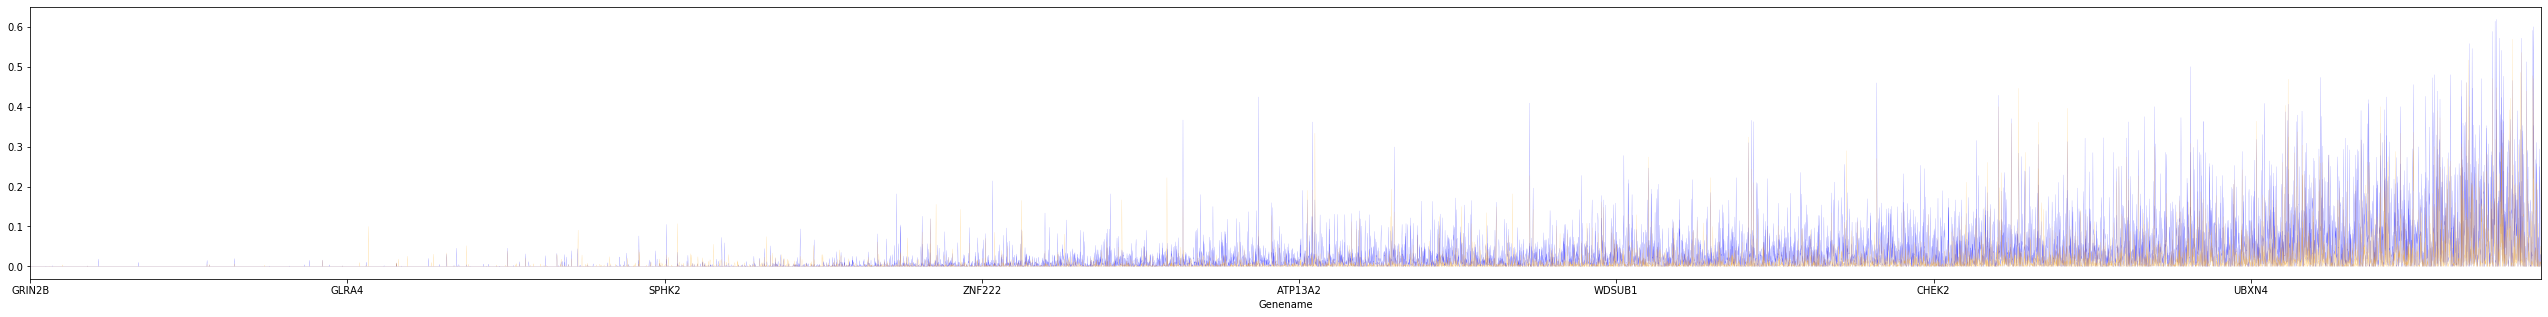

In [47]:
fig, ax = plt.subplots(figsize=(45, 5))
merged_expressed_only_and_sc_and_aggr['fraction_edited'].plot(style='-', linewidth=0.1, ax=ax, color='blue')
merged_expressed_only_and_sc_and_aggr['aggr_sc_fraction_edited'].plot(style='-', linewidth=0.1, ax=ax, color='orange')

# Correlation between edited fraction of bulk RBFOX-1000 and combined scRNA RBFOX

- RPS2 (bulk) vs RPS2 (scAggr All) in RPS2 (bulk) expressed genes: 0.595906
- RPS2 (bulk) vs RPS2 (scAggr bc8) in RPS2 (bulk) expressed genes: 0.692425
- RBFOX2 (bulk) vs RBFOX2 (scAggr 844) in RBFOX2 (bulk) expressed genes: 
- TIA1 (bulk) vs TIA1 (scAggr 518) in TIA1 (bulk) expressed genes: 0.597364


In [48]:
merged_expressed_only_and_sc_and_aggr[['fraction_edited','aggr_sc_fraction_edited','bg_fraction_edited','bg_aggr_sc_fraction_edited']].corr()

,fraction_edited,aggr_sc_fraction_edited,bg_fraction_edited,bg_aggr_sc_fraction_edited
fraction_edited,1.000000,0.782039,0.377992,0.091349
aggr_sc_fraction_edited,0.782039,1.000000,0.319378,0.072247
bg_fraction_edited,0.377992,0.319378,1.000000,0.055461
bg_aggr_sc_fraction_edited,0.091349,0.072247,0.055461,1.000000


# If we look at the last 200 (top 200 expressed in RBFOX2-1000), the bulk and combined scRNA mostly agree
- 'blue' is edited fraction from bulk RBFOX2-1000
- 'green' is edited fraction from combined 844 scRNA RBFOX2-expressed barcodes
- 'orange' is edited fraction from each scRNA RBFOX2-expressed barcode

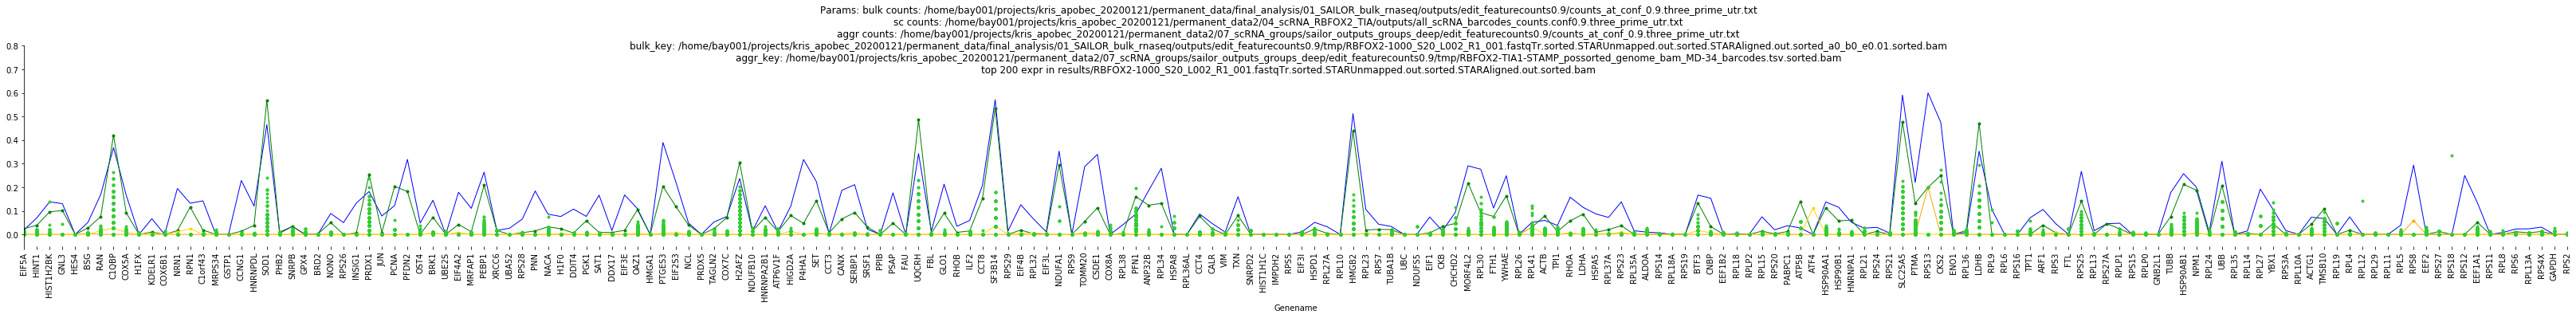

In [49]:
n = 200
merged_expressed_only_and_sc_and_aggr.sort_values(by=[bulk_expr_key], inplace=True)
iso = merged_expressed_only_and_sc_and_aggr.iloc[-n:] # last n genes
fig, ax = plt.subplots(figsize=(45, 5))
iso['fraction_edited'].plot(style='-', linewidth=1, ax=ax, color='blue', xticks=merged_expressed_only_and_sc_and_aggr.reset_index().index, rot=90)
iso['aggr_sc_fraction_edited'].plot(style='.-', linewidth=1, ax=ax, color='green')
iso['bg_aggr_sc_fraction_edited'].plot(style='.-', linewidth=1, ax=ax, color='orange')
iso['bg_fraction_edited'].plot(style='.-', linewidth=1, ax=ax, color='gold')

progress = tnrange(len(sc_edited_fraction.columns))
"""
I'm commenting out the "single cell edit fractions for now, since it takes kind of a long time to plot. I'll uncomment for the final figure.
"""
for column in sc_edited_fraction.columns:
    iso[column].plot(style='.', ax=ax, linewidth=0.01, color='limegreen')
    progress.update(1)

tx = ax.set_xticklabels(merged_expressed_only_and_sc_and_aggr.iloc[-n:].index, rotation=90)
fig.suptitle(
    "Params: bulk counts: {}\nsc counts: {}\naggr counts: {}\nbulk_key: {}\naggr_key: {}\ntop 200 expr in {}".format(
        bulk_counts_file,
        scRNA_counts_file,
        scRNA_all_counts_file,
        bulk_key,
        sc_key,
        bulk_expr_key,
    ),
    y=1.1
)
ax.set_ylim(-0.05, 0.8)
sns.despine(ax=ax, bottom=True, top=True, left=False, right=True)
plt.subplots_adjust(bottom=0.5)
plt.tight_layout()
fig.savefig(output_lineplot)

# the top 1000 expressed also kind of agrees? but harder to tell.

# What if we sort by fraction edited (in bulk)?

In [50]:
merged_expressed_only_and_sc_and_aggr.sort_values(by=['fraction_edited'], inplace=True)

# scatterplot 

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


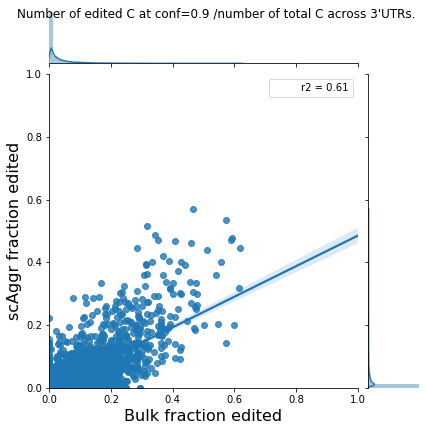

In [51]:
plot = sns.jointplot(
    x='fraction_edited', 
    y='aggr_sc_fraction_edited', 
    data=merged_expressed_only_and_sc_and_aggr, 
    kind="reg", 
    stat_func=r2,
    xlim=(0, 1), 
    ylim=(0, 1)
)

# JointGrid has a convenience function
plot.set_axis_labels('Bulk fraction edited', 'scAggr fraction edited', fontsize=16, )
plot.fig.suptitle("Number of edited C at conf={} /number of total C across 3'UTRs.".format(conf))
plot.fig.savefig(output_scatterplot)

### Misc notes:

Old correlations

- 0.778689 at 0.5 (RBFOX2 bulk vs RBFOX2 sc) 
- 0.782084 at 0.9 (RBFOX2 bulk vs RBFOX2 sc) 
- 0.80769 at 0.9 (RBFOX2 bulk @0.9 vs RBFOX2 sc @0.5) 
- 0.674504 at 0.9 (RBFOX2 bulk vs RPS2 sc)
- 0.688205 (RPS3 bulk vs RBFOX2 sc)
- 0.548973 (TIA1 bulk vs RBFOX2 sc)
- 0.093377 at 0.9 (RBFOX2 bulk vs APO sc)

- 0.732476 at 0.5 (TIA1 bulk vs TIA1 sc) 
- 0.597378 at 0.9 (TIA1 bulk vs TIA1 sc) 

- 0.715817 at 0.5 (RPS2-1000 vs RPS2 sc)
- 0.704538 at 0.9 (RPS2-1000 vs RPS2 sc)
- 0.649553 at 0.9 (RPS2-1000 vs RBFOX2 sc)

### We can tidy this up and plot a barplot if that makes more sense to do.

In [52]:
iso_bulk_fraction = iso[['fraction_edited']]
iso_bulk_fraction['class'] = 'bulk'
iso_bulk_fraction['color'] = 'blue'
iso_bulk_fraction.columns = ['fraction', 'class', 'color']

iso_sc_aggr_fraction = iso[['aggr_sc_fraction_edited']]
iso_sc_aggr_fraction['class'] = 'scAggr'
iso_sc_aggr_fraction['color'] = 'green'
iso_sc_aggr_fraction.columns = ['fraction', 'class', 'color']

iso_bg_fraction = iso[['bg_fraction_edited']]
iso_bg_fraction['class'] = 'bulk (Apobec)'
iso_bg_fraction['color'] = 'orange'
iso_bg_fraction.columns = ['fraction', 'class', 'color']

iso_melted = pd.concat([iso_bulk_fraction, iso_sc_aggr_fraction, iso_bg_fraction])
iso_melted.head()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:7: S

,fraction,class,color
Genename,,,
EIF5A,0.019608,bulk,blue
HINT1,0.070312,bulk,blue
HIST1H2BK,0.138298,bulk,blue
GNL3,0.130435,bulk,blue
HES4,0.000000,bulk,blue


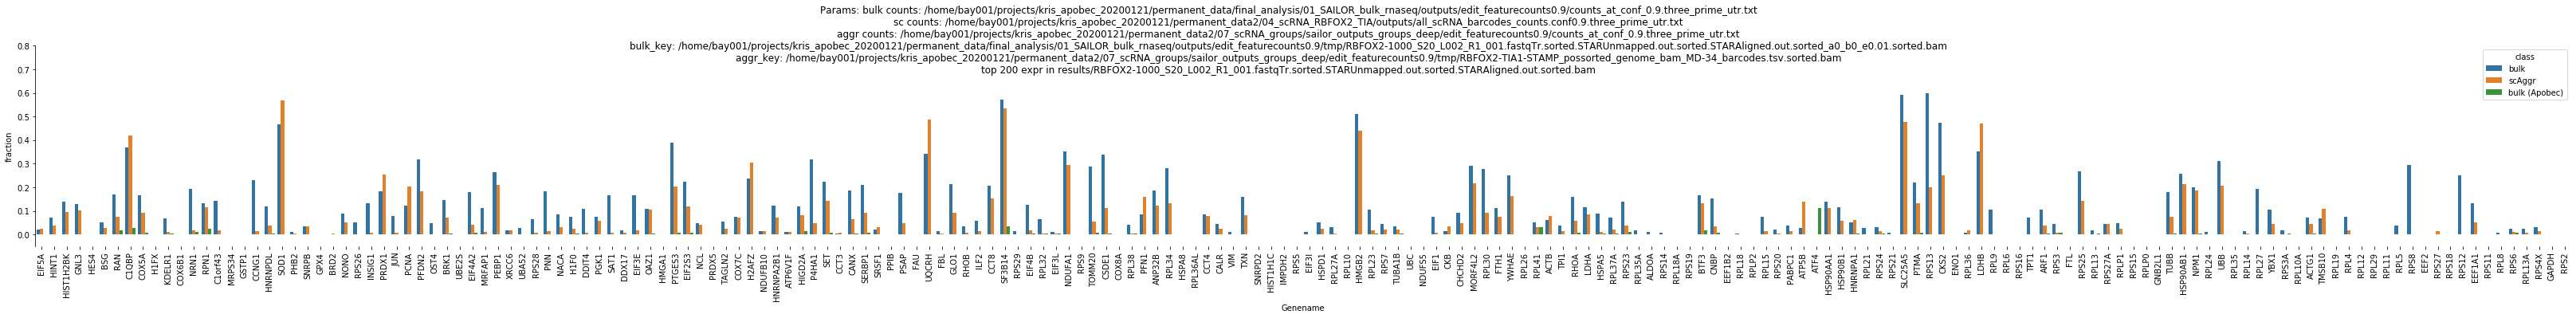

In [53]:
fig, ax = plt.subplots(figsize=(45, 5))
sns.barplot(x=iso_melted.index, y='fraction', hue='class', data=iso_melted, ax=ax)
tx = ax.set_xticklabels(iso_melted.index, rotation=90)
fig.suptitle(
    "Params: bulk counts: {}\nsc counts: {}\naggr counts: {}\nbulk_key: {}\naggr_key: {}\ntop 200 expr in {}".format(
        bulk_counts_file,
        scRNA_counts_file,
        scRNA_all_counts_file,
        bulk_key,
        sc_key,
        bulk_expr_key,
    ),
    y=1.1
)
ax.set_ylim(-0.05, 0.8)
sns.despine(ax=ax, bottom=True, top=True, left=False, right=True)
plt.subplots_adjust(bottom=0.5)
plt.tight_layout()
fig.savefig(output_lineplot + ".bar.pdf")